In [71]:
require(ggplot2)
require(reshape2)
require(MASS)
require(car)
require(dplyr)

Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:car’:

    recode

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [1]:
vanillaData <- read.csv("/Users/imnfkhri/R/DataByte/AllCaseStudies/Logistic Regression/Proactive Attrition Management-Logistic Regression Case Study.csv")


In [2]:
# Dropping churn column, will use churndep as y
vanillaData$CHURN <- NULL

In [3]:
# Overview of data
summary(vanillaData)

    REVENUE             MOU            RECCHRGE         DIRECTAS       
 Min.   :  -6.17   Min.   :   0.0   Min.   :-11.29   Min.   :  0.0000  
 1st Qu.:  33.64   1st Qu.: 158.2   1st Qu.: 30.00   1st Qu.:  0.0000  
 Median :  48.53   Median : 366.0   Median : 44.99   Median :  0.2500  
 Mean   :  58.85   Mean   : 525.7   Mean   : 46.88   Mean   :  0.8948  
 3rd Qu.:  71.03   3rd Qu.: 721.8   3rd Qu.: 59.99   3rd Qu.:  0.9900  
 Max.   :1223.38   Max.   :7667.8   Max.   :399.99   Max.   :159.3900  
 NA's   :216       NA's   :216      NA's   :216      NA's   :216       
    OVERAGE             ROAM             CHANGEM            CHANGER         
 Min.   :   0.00   Min.   :   0.000   Min.   :-3875.00   Min.   :-1107.740  
 1st Qu.:   0.00   1st Qu.:   0.000   1st Qu.:  -83.00   1st Qu.:   -7.110  
 Median :   2.50   Median :   0.000   Median :   -5.00   Median :   -0.290  
 Mean   :  40.09   Mean   :   1.222   Mean   :  -10.85   Mean   :   -1.206  
 3rd Qu.:  40.75   3rd Qu.:   0.260   3

In [4]:
str(vanillaData)

'data.frame':	71047 obs. of  77 variables:
 $ REVENUE : num  57.5 82.3 31.7 62.1 25.2 ...
 $ MOU     : num  482.8 1312.2 25.5 97.5 2.5 ...
 $ RECCHRGE: num  37.4 75 30 66 25 ...
 $ DIRECTAS: num  0.25 1.24 0.25 2.48 0 2.23 0.25 0 0.74 0 ...
 $ OVERAGE : num  22.8 0 0 0 0 ...
 $ ROAM    : num  0 0 0 0 0 35.5 0 0 1.29 0 ...
 $ CHANGEM : num  532.2 156.8 59.5 23.5 -2.5 ...
 $ CHANGER : num  50.99 8.14 4.03 6.82 -0.23 ...
 $ DROPVCE : num  8.33 52 0 0 0 9 3.33 2 2.67 1.67 ...
 $ BLCKVCE : num  1 7.67 1 0.33 0 0 1.67 0.67 6 0.33 ...
 $ UNANSVCE: num  61.33 76 2.33 4 0.33 ...
 $ CUSTCARE: num  1.67 4.33 0 4 0 0.33 1 0 4.33 0.33 ...
 $ THREEWAY: num  0.33 1.33 0 0 0 0 0 0 0 0 ...
 $ MOUREC  : num  55.28 200.32 0 0 1.13 ...
 $ OUTCALLS: num  46.33 370.33 0 3.67 0.33 ...
 $ INCALLS : num  6.33 147 0 0 0 4.67 3.67 4.67 8.33 5.67 ...
 $ PEAKVCE : num  83.67 555.67 1.67 7.67 0.67 ...
 $ OPEAKVCE: num  157 303.67 1.67 7.33 0.67 ...
 $ DROPBLK : num  9.33 59.67 1 0.33 0 ...
 $ CALLFWDV: num  0 0 0 0

In [5]:
# Custom function for diagnosis
mystats <- function(x){
  
  n = length(x)
  nmiss = sum(is.na(x))
  nmiss_pct = mean(is.na(x))
  sum = sum(x, na.rm=T)
  mean = mean(x, na.rm=T)
  median = quantile(x, p=0.5, na.rm=T)
  std = sd(x, na.rm=T)
  var = var(x, na.rm=T)
  range = max(x, na.rm=T)-min(x, na.rm=T)
  pctl = quantile(x, p=c(0, 0.01, 0.05,0.1,0.25,0.5, 0.75,0.9,0.95,0.99,1), na.rm=T)
  return(c(N=n, Nmiss =nmiss, Nmiss_pct = nmiss_pct, sum=sum, avg=mean, meidan=median, std=std, var=var, range=range, pctl=pctl))
  
}

In [6]:
# Getting only numeric columns and running custom diagnosis
numericVars <- names(vanillaData)[sapply(vanillaData, FUN=is.numeric)]
vanillaStats <- data.frame(apply(vanillaData[numericVars], 2, FUN=mystats))
interest <- vanillaData[numericVars]

No id variables; using all as measure variables


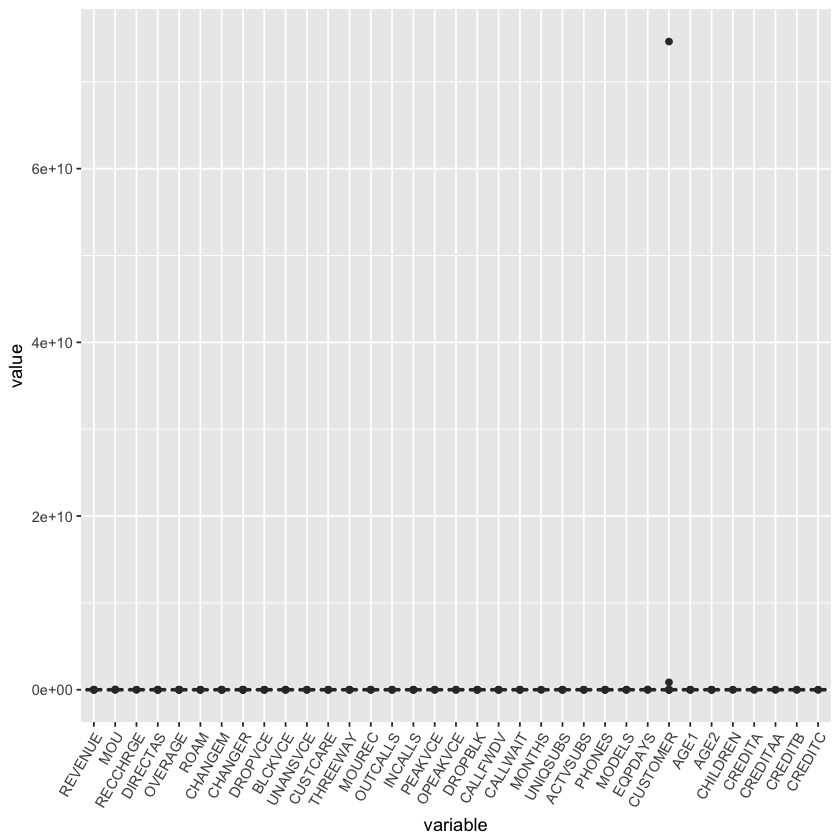

In [9]:
# Visualize data to spot outlier
interestedmelted <- reshape2::melt(vanillaStats[numericVars][,1:35])
ggplot(interestedmelted) + aes(x = variable, y = value) + geom_boxplot() + theme(axis.text.x = element_text(angle = 60, hjust = 1))

No id variables; using all as measure variables


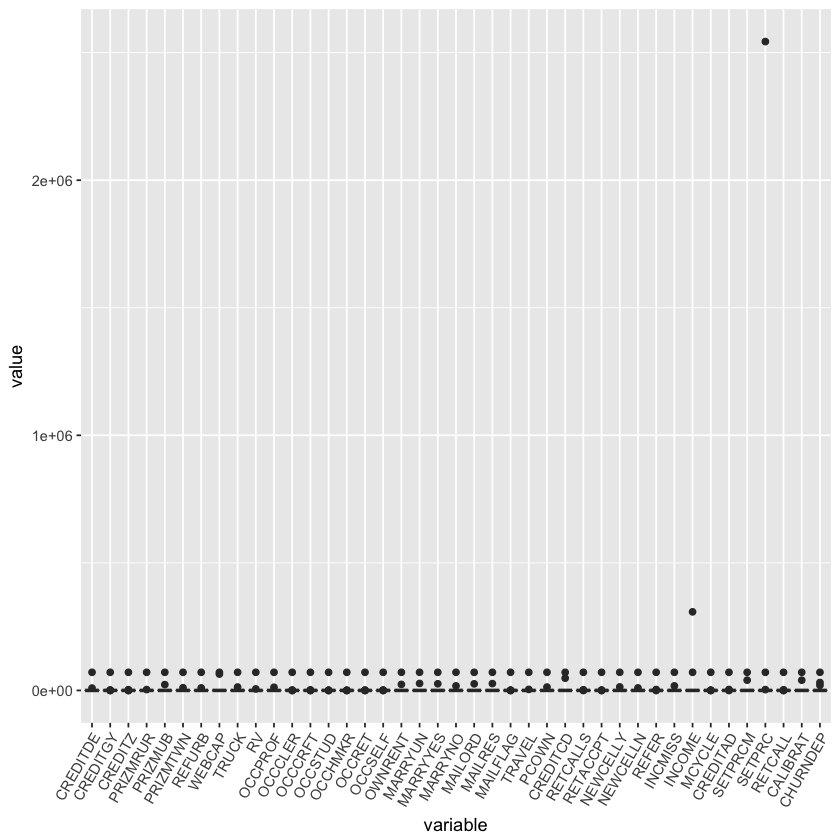

In [10]:
interestedmelted <- reshape2::melt(vanillaStats[numericVars][,36:76])
ggplot(interestedmelted) + aes(x = variable, y = value) + geom_boxplot() + theme(axis.text.x = element_text(angle = 60, hjust = 1))

In [12]:
# Outlier treatment using IQR Methods
outlier_treat <- function(x){
  UC1 <-  quantile(x, p=0.99,na.rm=T)
  LC1 <-  quantile(x, p=0.01,na.rm=T)
  
  # UC2 = mean(x,na.rm=T) + 3*sd(x, na.rm=T)
  # LC2 = mean(x,na.rm=T) - 3*sd(x, na.rm=T)
  
  x <- ifelse(x>UC1, UC1, x)
  x <- ifelse(x<LC1, LC1, x)
  
  #x[x>UC1]=UC1
  #x[x<LC1]=LC1
  
  return(x)
  
}

In [16]:
# Running outlier treatment
interest <- data.frame(apply(vanillaData[numericVars], 2, FUN=outlier_treat))

No id variables; using all as measure variables
Warning message:
“Removed 4791 rows containing non-finite values (stat_boxplot).”

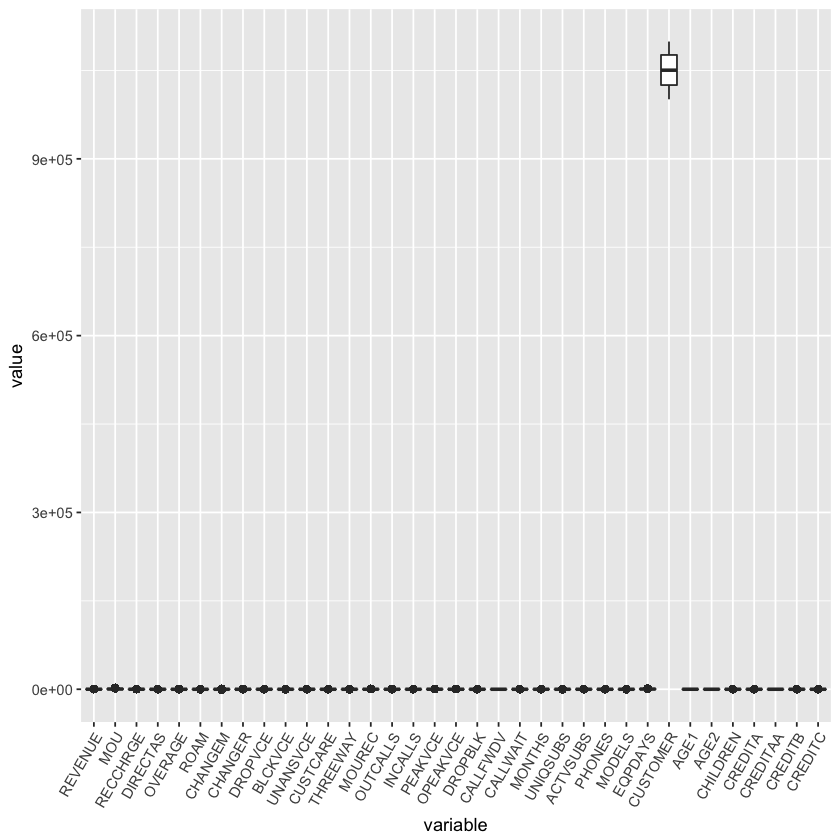

In [17]:
# Visualizing data after outlier treatment
interestedmelted <- reshape2::melt(interest[,1:35])
ggplot(interestedmelted) + aes(x = variable, y = value) + geom_boxplot() + theme(axis.text.x = element_text(angle = 60, hjust = 1))

No id variables; using all as measure variables
Warning message:
“Removed 31047 rows containing non-finite values (stat_boxplot).”

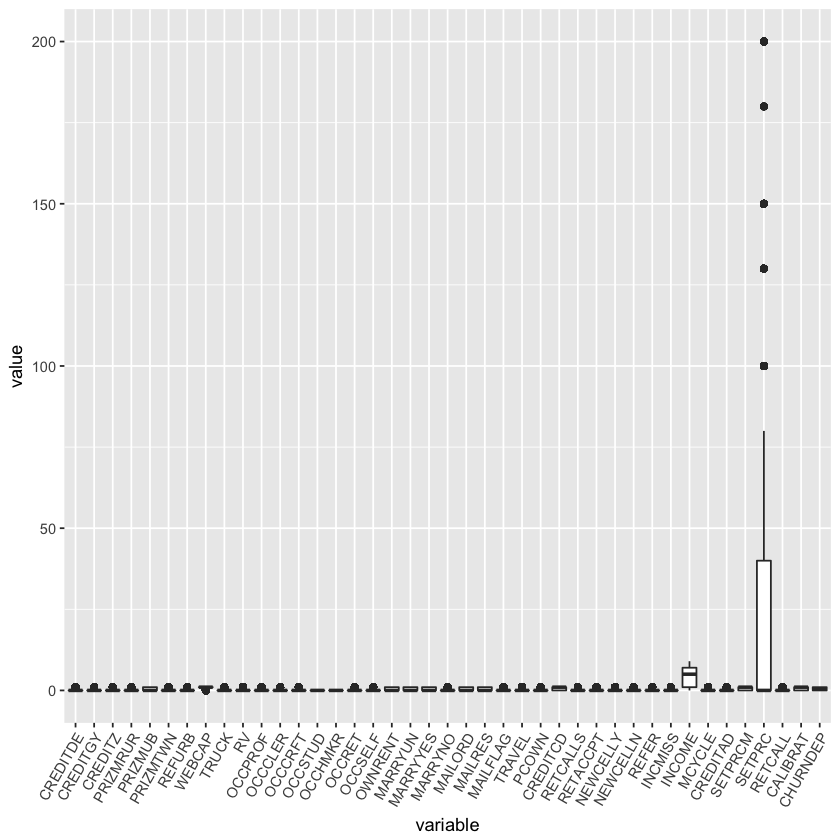

In [18]:
interestedmelted <- reshape2::melt(interest[,36:76])
ggplot(interestedmelted) + aes(x = variable, y = value) + geom_boxplot() + theme(axis.text.x = element_text(angle = 60, hjust = 1))

# Missing value treatment

In [19]:
interest$REVENUE[is.na(interest$REVENUE)] <- mean(interest$REVENUE, na.rm = T)
interest$MOU[is.na(interest$MOU)] <- mean(interest$MOU, na.rm = T)
interest$RECCHRGE[is.na(interest$RECCHRGE)] <- mean(interest$RECCHRGE, na.rm=T)
interest$DIRECTAS[is.na(interest$DIRECTAS)] <- mean(interest$DIRECTAS, na.rm=T)
interest$OVERAGE[is.na(interest$OVERAGE)] <- mean(interest$OVERAGE, na.rm = T)
interest$ROAM[is.na(interest$ROAM)] <- mean(interest$ROAM, na.rm = T)
interest$CHANGEM[is.na(interest$CHANGEM)] <- mean(interest$CHANGEM, na.rm=T)
interest$CHANGER[is.na(interest$CHANGER)] <- mean(interest$CHANGER, na.rm=T)
interest$AGE1[is.na(interest$AGE1)] <- median(interest$AGE1, na.rm=T)
interest$AGE2[is.na(interest$AGE2)] <- median(interest$AGE2, na.rm = T)
interest$EQPDAYS[is.na(interest$EQPDAYS)] <- mean(interest$EQPDAYS, na.rm = T)
interest$INCOME[is.na(interest$INCOME)] <- median(interest$INCOME, na.rm = T)
interest$PHONES[is.na(interest$PHONES)] <- median(interest$PHONES, na.rm = T)
interest$MODELS[is.na(interest$MODELS)] <- median(interest$MODELS, na.rm = T)

# Visualizing after m.i.a treatment

No id variables; using all as measure variables


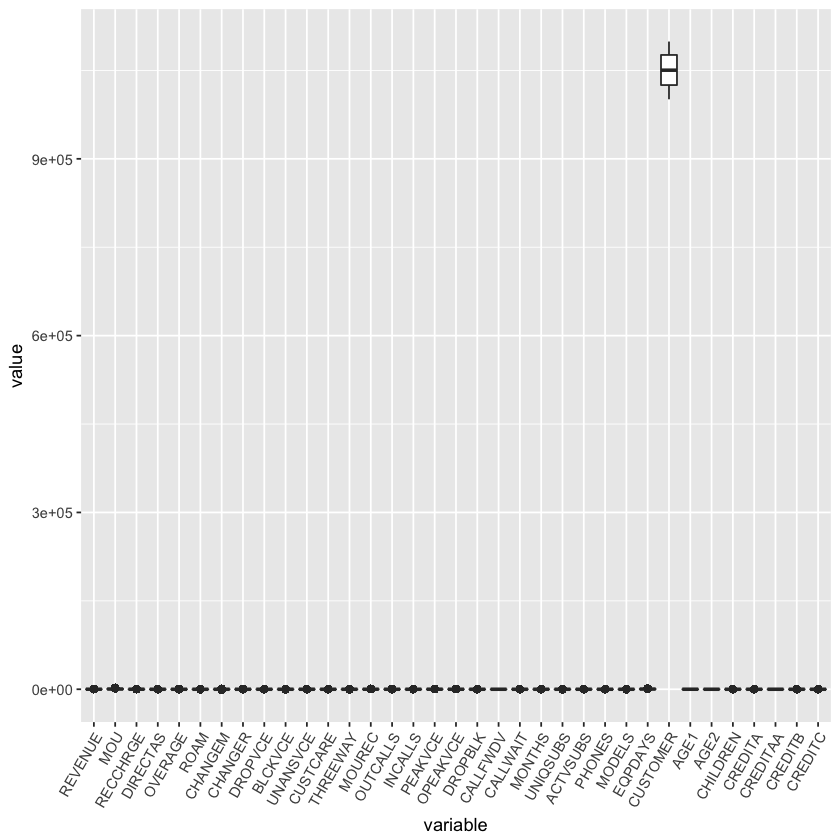

In [20]:
interestedmelted <- reshape2::melt(interest[,1:35])
ggplot(interestedmelted) + aes(x = variable, y = value) + geom_boxplot() + theme(axis.text.x = element_text(angle = 60, hjust = 1))



No id variables; using all as measure variables


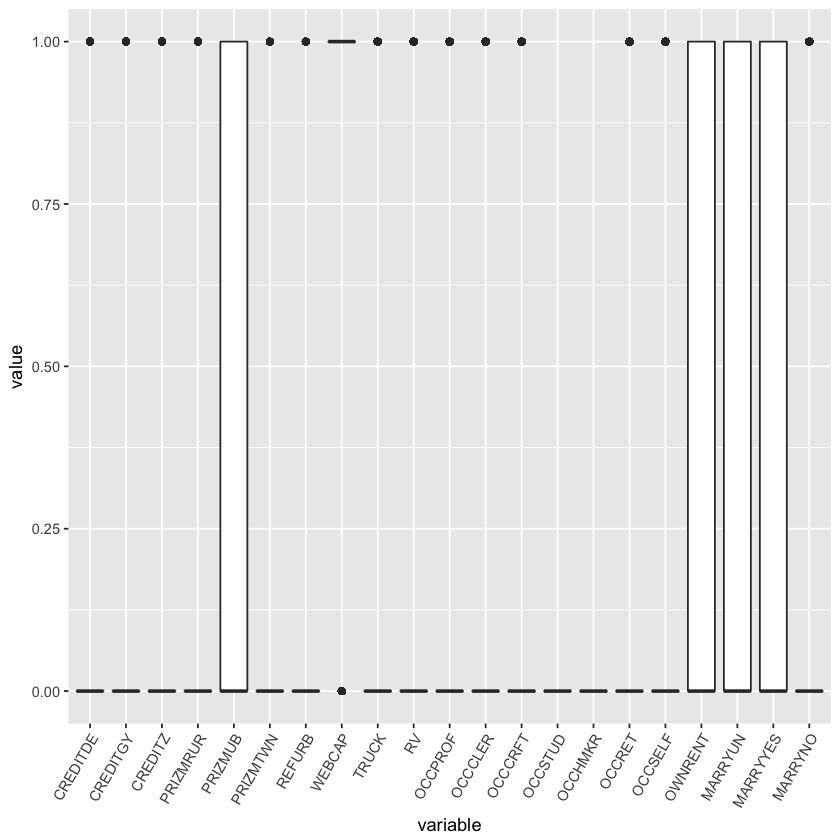

In [21]:
interestedmelted <- reshape2::melt(interest[,36:56])
ggplot(interestedmelted) + aes(x = variable, y = value) + geom_boxplot() + theme(axis.text.x = element_text(angle = 60, hjust = 1))


No id variables; using all as measure variables
Warning message:
“Removed 31047 rows containing non-finite values (stat_boxplot).”

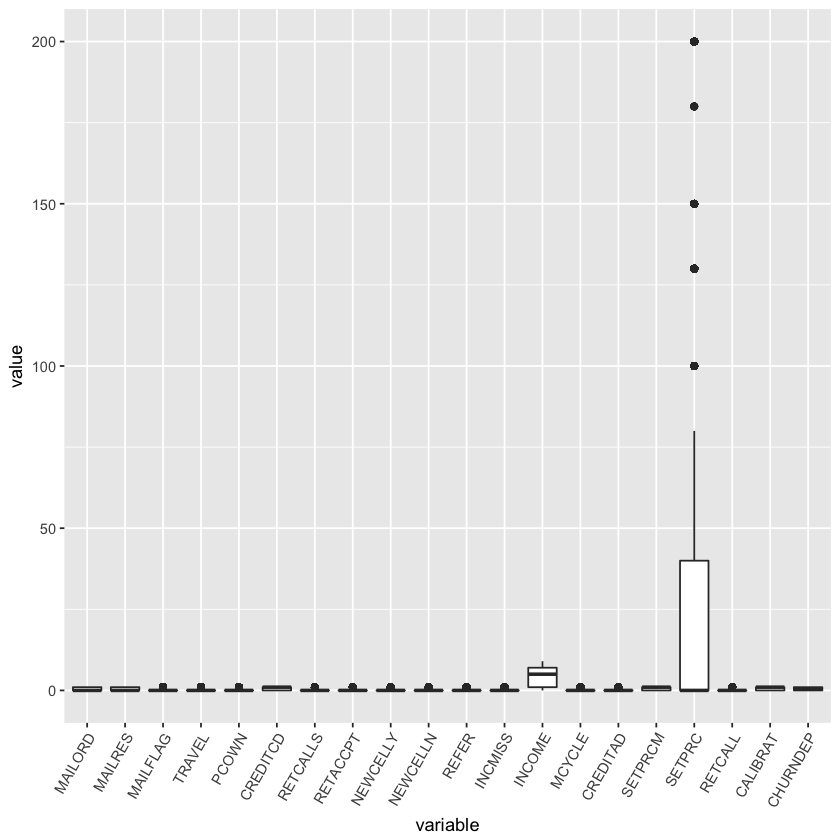

In [22]:

interestedmelted <- reshape2::melt(interest[,57:76])
ggplot(interestedmelted) + aes(x = variable, y = value) + geom_boxplot() + theme(axis.text.x = element_text(angle = 60, hjust = 1))

# Splitting Data

In [23]:
calibration <- interest[interest$CALIBRAT==1,]
calibration$CALIBRAT <- NULL

valtest <- interest[interest$CALIBRAT==0,]
valtest$CALIBRAT <- NULL

# Generating First model

In [24]:
fit<-glm(CHURNDEP~.,data = calibration,family = binomial(logit))
summary(fit)


Call:
glm(formula = CHURNDEP ~ ., family = binomial(logit), data = calibration)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.25412  -1.13675  -0.05962   1.14173   2.07633  

Coefficients: (6 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.130e+00  6.374e-01   3.342 0.000833 ***
REVENUE      1.311e-03  8.858e-04   1.481 0.138738    
MOU         -2.943e-04  5.124e-05  -5.744 9.26e-09 ***
RECCHRGE    -2.764e-03  9.653e-04  -2.863 0.004198 ** 
DIRECTAS    -3.301e-03  7.456e-03  -0.443 0.657961    
OVERAGE      1.794e-03  3.394e-04   5.284 1.26e-07 ***
ROAM         1.888e-02  3.786e-03   4.985 6.18e-07 ***
CHANGEM     -5.620e-04  5.972e-05  -9.411  < 2e-16 ***
CHANGER      2.312e-03  4.488e-04   5.152 2.57e-07 ***
DROPVCE     -1.745e-03  6.227e-03  -0.280 0.779343    
BLCKVCE     -8.622e-03  6.260e-03  -1.377 0.168449    
UNANSVCE     7.218e-04  5.442e-04   1.327 0.184669    
CUSTCARE    -6.585e-03  

# Using StepWise regression to refine model

In [26]:
step1 <- MASS::stepAIC(fit, direction = 'both', use.parallel=TRUE, num.cores = 2)

Start:  AIC=53682.4
CHURNDEP ~ REVENUE + MOU + RECCHRGE + DIRECTAS + OVERAGE + ROAM + 
    CHANGEM + CHANGER + DROPVCE + BLCKVCE + UNANSVCE + CUSTCARE + 
    THREEWAY + MOUREC + OUTCALLS + INCALLS + PEAKVCE + OPEAKVCE + 
    DROPBLK + CALLFWDV + CALLWAIT + MONTHS + UNIQSUBS + ACTVSUBS + 
    PHONES + MODELS + EQPDAYS + CUSTOMER + AGE1 + AGE2 + CHILDREN + 
    CREDITA + CREDITAA + CREDITB + CREDITC + CREDITDE + CREDITGY + 
    CREDITZ + PRIZMRUR + PRIZMUB + PRIZMTWN + REFURB + WEBCAP + 
    TRUCK + RV + OCCPROF + OCCCLER + OCCCRFT + OCCSTUD + OCCHMKR + 
    OCCRET + OCCSELF + OWNRENT + MARRYUN + MARRYYES + MARRYNO + 
    MAILORD + MAILRES + MAILFLAG + TRAVEL + PCOWN + CREDITCD + 
    RETCALLS + RETACCPT + NEWCELLY + NEWCELLN + REFER + INCMISS + 
    INCOME + MCYCLE + CREDITAD + SETPRCM + SETPRC + RETCALL


Step:  AIC=53682.4
CHURNDEP ~ REVENUE + MOU + RECCHRGE + DIRECTAS + OVERAGE + ROAM + 
    CHANGEM + CHANGER + DROPVCE + BLCKVCE + UNANSVCE + CUSTCARE + 
    THREEWAY + MOUREC + OUTCAL

           Df Deviance   AIC
- CREDITA   1    53544 53678
- OPEAKVCE  1    53544 53678
- TRAVEL    1    53544 53678
- MAILORD   1    53544 53678
- MODELS    1    53544 53678
- RV        1    53544 53678
- NEWCELLN  1    53544 53678
- CREDITGY  1    53544 53678
- DROPVCE   1    53544 53678
- OCCCRFT   1    53545 53679
- MOUREC    1    53545 53679
- DIRECTAS  1    53545 53679
- MAILFLAG  1    53545 53679
- OCCRET    1    53545 53679
- OCCCLER   1    53545 53679
- REFER     1    53545 53679
- TRUCK     1    53545 53679
- OCCSELF   1    53545 53679
- CREDITCD  1    53545 53679
- OCCPROF   1    53545 53679
- CALLWAIT  1    53545 53679
- PRIZMTWN  1    53546 53680
- PCOWN     1    53546 53680
- PRIZMRUR  1    53546 53680
- CREDITAA  1    53546 53680
- MCYCLE    1    53546 53680
- MAILRES   1    53546 53680
- UNANSVCE  1    53546 53680
- OUTCALLS  1    53546 53680
- BLCKVCE   1    53546 53680
<none>           53544 53680
- REVENUE   1    53547 53681
- AGE2      1    53547 53681
- CREDITC   1 

           Df Deviance   AIC
- MAILORD   1    53544 53672
- MODELS    1    53544 53672
- RV        1    53544 53672
- NEWCELLN  1    53544 53672
- DROPVCE   1    53544 53672
- CREDITGY  1    53545 53673
- OCCCRFT   1    53545 53673
- MOUREC    1    53545 53673
- DIRECTAS  1    53545 53673
- MAILFLAG  1    53545 53673
- OCCRET    1    53545 53673
- OCCCLER   1    53545 53673
- REFER     1    53545 53673
- TRUCK     1    53545 53673
- OCCSELF   1    53545 53673
- OCCPROF   1    53545 53673
- CREDITCD  1    53545 53673
- CALLWAIT  1    53545 53673
- PRIZMTWN  1    53546 53674
- PCOWN     1    53546 53674
- PRIZMRUR  1    53546 53674
- MCYCLE    1    53546 53674
- MAILRES   1    53546 53674
- BLCKVCE   1    53546 53674
- UNANSVCE  1    53546 53674
<none>           53544 53674
- OUTCALLS  1    53546 53674
- REVENUE   1    53547 53675
- AGE2      1    53547 53675
- SETPRCM   1    53547 53675
- PRIZMUB   1    53547 53675
- MARRYYES  1    53548 53676
- INCMISS   1    53548 53676
- CUSTCARE  1 

           Df Deviance   AIC
- NEWCELLN  1    53545 53667
- DROPVCE   1    53545 53667
- CREDITGY  1    53545 53667
- MOUREC    1    53545 53667
- OCCCRFT   1    53545 53667
- DIRECTAS  1    53545 53667
- MAILFLAG  1    53545 53667
- OCCRET    1    53545 53667
- OCCCLER   1    53545 53667
- REFER     1    53545 53667
- OCCSELF   1    53545 53667
- TRUCK     1    53545 53667
- OCCPROF   1    53545 53667
- CREDITCD  1    53545 53667
- CALLWAIT  1    53546 53668
- PRIZMTWN  1    53546 53668
- PCOWN     1    53546 53668
- PRIZMRUR  1    53546 53668
- MCYCLE    1    53546 53668
- BLCKVCE   1    53546 53668
- UNANSVCE  1    53546 53668
<none>           53544 53668
- OUTCALLS  1    53546 53668
- REVENUE   1    53547 53669
- AGE2      1    53547 53669
- SETPRCM   1    53547 53669
- PRIZMUB   1    53547 53669
- MARRYYES  1    53548 53670
- INCMISS   1    53548 53670
- CUSTCARE  1    53548 53670
+ RV        1    53544 53670
+ MODELS    1    53544 53670
+ MAILORD   1    53544 53670
+ TRAVEL    1 


Step:  AIC=53660.86
CHURNDEP ~ REVENUE + MOU + RECCHRGE + DIRECTAS + OVERAGE + ROAM + 
    CHANGEM + CHANGER + BLCKVCE + UNANSVCE + CUSTCARE + THREEWAY + 
    OUTCALLS + INCALLS + PEAKVCE + DROPBLK + CALLWAIT + MONTHS + 
    UNIQSUBS + ACTVSUBS + PHONES + EQPDAYS + CUSTOMER + AGE1 + 
    AGE2 + CHILDREN + CREDITAA + CREDITB + CREDITC + CREDITDE + 
    PRIZMRUR + PRIZMUB + PRIZMTWN + REFURB + WEBCAP + TRUCK + 
    OCCPROF + OCCCLER + OCCCRFT + OCCRET + OCCSELF + MARRYUN + 
    MARRYYES + MAILRES + MAILFLAG + PCOWN + CREDITCD + RETCALLS + 
    RETACCPT + NEWCELLY + REFER + INCMISS + INCOME + MCYCLE + 
    CREDITAD + SETPRCM + SETPRC

           Df Deviance   AIC
- OCCCRFT   1    53545 53659
- MAILFLAG  1    53545 53659
- DIRECTAS  1    53545 53659
- OCCRET    1    53545 53659
- OCCCLER   1    53545 53659
- REFER     1    53545 53659
- OCCSELF   1    53545 53659
- TRUCK     1    53546 53660
- OCCPROF   1    53546 53660
- CREDITCD  1    53546 53660
- PRIZMTWN  1    53546 53660
- CALLWAIT 

           Df Deviance   AIC
- DIRECTAS  1    53546 53654
- OCCCLER   1    53546 53654
- REFER     1    53546 53654
- OCCSELF   1    53546 53654
- OCCPROF   1    53546 53654
- TRUCK     1    53546 53654
- CREDITCD  1    53546 53654
- PRIZMTWN  1    53547 53655
- PCOWN     1    53547 53655
- CALLWAIT  1    53547 53655
- PRIZMRUR  1    53547 53655
- MCYCLE    1    53547 53655
- UNANSVCE  1    53547 53655
- OUTCALLS  1    53547 53655
<none>           53545 53655
- REVENUE   1    53548 53656
- AGE2      1    53548 53656
- SETPRCM   1    53548 53656
- PRIZMUB   1    53548 53656
- MARRYYES  1    53549 53657
- INCMISS   1    53549 53657
- CUSTCARE  1    53549 53657
+ OCCRET    1    53545 53657
+ MAILFLAG  1    53545 53657
+ MOUREC    1    53545 53657
+ OCCCRFT   1    53545 53657
+ CREDITGY  1    53545 53657
+ DROPVCE   1    53545 53657
+ NEWCELLN  1    53545 53657
+ CREDITA   1    53545 53657
+ RV        1    53545 53657
+ MODELS    1    53545 53657
+ MAILORD   1    53545 53657
+ TRAVEL    1 


Step:  AIC=53649.09
CHURNDEP ~ REVENUE + MOU + RECCHRGE + OVERAGE + ROAM + CHANGEM + 
    CHANGER + BLCKVCE + UNANSVCE + CUSTCARE + THREEWAY + OUTCALLS + 
    INCALLS + PEAKVCE + DROPBLK + CALLWAIT + MONTHS + UNIQSUBS + 
    ACTVSUBS + PHONES + EQPDAYS + CUSTOMER + AGE1 + AGE2 + CHILDREN + 
    CREDITAA + CREDITB + CREDITC + CREDITDE + PRIZMRUR + PRIZMUB + 
    PRIZMTWN + REFURB + WEBCAP + TRUCK + OCCPROF + MARRYUN + 
    MARRYYES + MAILRES + PCOWN + CREDITCD + RETCALLS + RETACCPT + 
    NEWCELLY + INCMISS + INCOME + MCYCLE + CREDITAD + SETPRCM + 
    SETPRC

           Df Deviance   AIC
- OCCPROF   1    53548 53648
- TRUCK     1    53548 53648
- CREDITCD  1    53548 53648
- PRIZMTWN  1    53548 53648
- PCOWN     1    53548 53648
- CALLWAIT  1    53548 53648
- PRIZMRUR  1    53549 53649
- MCYCLE    1    53549 53649
- UNANSVCE  1    53549 53649
- OUTCALLS  1    53549 53649
<none>           53547 53649
- REVENUE   1    53549 53649
- AGE2      1    53549 53649
- PRIZMUB   1    53550 5365

           Df Deviance   AIC
- PCOWN     1    53550 53644
- PRIZMTWN  1    53550 53644
- CALLWAIT  1    53550 53644
- PRIZMRUR  1    53551 53645
- OUTCALLS  1    53551 53645
- UNANSVCE  1    53551 53645
- AGE2      1    53551 53645
- MCYCLE    1    53551 53645
- REVENUE   1    53551 53645
<none>           53549 53645
- PRIZMUB   1    53552 53646
- SETPRCM   1    53552 53646
- MARRYYES  1    53552 53646
+ TRUCK     1    53548 53646
+ CREDITCD  1    53548 53646
+ OCCCLER   1    53549 53647
+ OCCPROF   1    53549 53647
- CUSTCARE  1    53553 53647
+ OCCSELF   1    53549 53647
+ REFER     1    53549 53647
+ RV        1    53549 53647
+ MAILFLAG  1    53549 53647
+ DIRECTAS  1    53549 53647
+ MOUREC    1    53549 53647
+ OCCRET    1    53549 53647
+ CREDITGY  1    53549 53647
+ OWNRENT   1    53549 53647
+ DROPVCE   1    53549 53647
+ OCCCRFT   1    53549 53647
+ NEWCELLN  1    53549 53647
+ CREDITA   1    53549 53647
+ TRAVEL    1    53549 53647
+ MODELS    1    53549 53647
+ MAILORD   1 


Step:  AIC=53641.82
CHURNDEP ~ REVENUE + MOU + RECCHRGE + OVERAGE + ROAM + CHANGEM + 
    CHANGER + BLCKVCE + UNANSVCE + CUSTCARE + THREEWAY + OUTCALLS + 
    INCALLS + PEAKVCE + DROPBLK + MONTHS + UNIQSUBS + ACTVSUBS + 
    PHONES + EQPDAYS + CUSTOMER + AGE1 + AGE2 + CHILDREN + CREDITAA + 
    CREDITB + CREDITC + CREDITDE + PRIZMUB + REFURB + WEBCAP + 
    MARRYUN + MARRYYES + MAILRES + RETCALLS + RETACCPT + NEWCELLY + 
    INCMISS + INCOME + MCYCLE + CREDITAD + SETPRCM + SETPRC

           Df Deviance   AIC
- AGE2      1    53555 53641
- OUTCALLS  1    53556 53642
- REVENUE   1    53556 53642
<none>           53554 53642
- UNANSVCE  1    53556 53642
- MCYCLE    1    53556 53642
+ CALLWAIT  1    53552 53642
- SETPRCM   1    53557 53643
+ PRIZMRUR  1    53553 53643
+ TRUCK     1    53553 53643
+ PCOWN     1    53553 53643
+ PRIZMTWN  1    53553 53643
+ CREDITCD  1    53553 53643
+ OCCCLER   1    53553 53643
+ MOUREC    1    53553 53643
+ RV        1    53553 53643
+ REFER     1    535

In [28]:
step1$call

glm(formula = CHURNDEP ~ MOU + RECCHRGE + OVERAGE + ROAM + CHANGEM + 
    CHANGER + BLCKVCE + UNANSVCE + CUSTCARE + THREEWAY + INCALLS + 
    PEAKVCE + DROPBLK + MONTHS + UNIQSUBS + ACTVSUBS + PHONES + 
    EQPDAYS + CUSTOMER + AGE1 + CHILDREN + CREDITAA + CREDITB + 
    CREDITC + CREDITDE + PRIZMUB + REFURB + WEBCAP + MARRYUN + 
    MARRYYES + MAILRES + RETCALLS + RETACCPT + NEWCELLY + INCMISS + 
    INCOME + MCYCLE + CREDITAD + SETPRCM + SETPRC, family = binomial(logit), 
    data = calibration)

# Second model

In [30]:
fit2 <- glm(formula = CHURNDEP ~ MOU + RECCHRGE + OVERAGE + ROAM + CHANGEM + 
    CHANGER + BLCKVCE + UNANSVCE + CUSTCARE + THREEWAY + INCALLS + 
    PEAKVCE + DROPBLK + MONTHS + UNIQSUBS + ACTVSUBS + PHONES + 
    EQPDAYS + CUSTOMER + AGE1 + CHILDREN + CREDITAA + CREDITB + 
    CREDITC + CREDITDE + PRIZMUB + REFURB + WEBCAP + MARRYUN + 
    MARRYYES + MAILRES + RETCALLS + RETACCPT + NEWCELLY + INCMISS + 
    INCOME + MCYCLE + CREDITAD + SETPRCM + SETPRC, family = binomial(logit), 
    data = calibration)
summary(fit2)


Call:
glm(formula = CHURNDEP ~ MOU + RECCHRGE + OVERAGE + ROAM + CHANGEM + 
    CHANGER + BLCKVCE + UNANSVCE + CUSTCARE + THREEWAY + INCALLS + 
    PEAKVCE + DROPBLK + MONTHS + UNIQSUBS + ACTVSUBS + PHONES + 
    EQPDAYS + CUSTOMER + AGE1 + CHILDREN + CREDITAA + CREDITB + 
    CREDITC + CREDITDE + PRIZMUB + REFURB + WEBCAP + MARRYUN + 
    MARRYYES + MAILRES + RETCALLS + RETACCPT + NEWCELLY + INCMISS + 
    INCOME + MCYCLE + CREDITAD + SETPRCM + SETPRC, family = binomial(logit), 
    data = calibration)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.22387  -1.13675  -0.04374   1.14278   2.09049  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.268e+00  6.264e-01   3.620 0.000294 ***
MOU         -2.641e-04  4.262e-05  -6.198 5.73e-10 ***
RECCHRGE    -1.727e-03  6.145e-04  -2.811 0.004944 ** 
OVERAGE      2.227e-03  1.795e-04  12.407  < 2e-16 ***
ROAM         2.115e-02  3.490e-03   6.060 1.37e-09 ***
CHANGEM     -5.659e-0

In [44]:
# Further refining the variables

fit3 <- glm(formula = CHURNDEP ~ RECCHRGE + OVERAGE + ROAM + CHANGEM + 
    CHANGER + BLCKVCE + THREEWAY + INCALLS + 
    PEAKVCE + DROPBLK + MONTHS + UNIQSUBS + ACTVSUBS + PHONES + 
    EQPDAYS + CUSTOMER + AGE1 + CHILDREN + CREDITAA + CREDITB + 
    CREDITC + CREDITDE + PRIZMUB + REFURB + WEBCAP  +
    MAILRES + RETCALLS + RETACCPT + NEWCELLY  + 
    INCOME + CREDITAD  + SETPRC, family = binomial(logit), 
    data = calibration)
summary(fit3)


Call:
glm(formula = CHURNDEP ~ RECCHRGE + OVERAGE + ROAM + CHANGEM + 
    CHANGER + BLCKVCE + THREEWAY + INCALLS + PEAKVCE + DROPBLK + 
    MONTHS + UNIQSUBS + ACTVSUBS + PHONES + EQPDAYS + CUSTOMER + 
    AGE1 + CHILDREN + CREDITAA + CREDITB + CREDITC + CREDITDE + 
    PRIZMUB + REFURB + WEBCAP + MAILRES + RETCALLS + RETACCPT + 
    NEWCELLY + INCOME + CREDITAD + SETPRC, family = binomial(logit), 
    data = calibration)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.21169  -1.13698  -0.05806   1.14508   2.07405  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.474e+00  6.239e-01   3.964 7.36e-05 ***
RECCHRGE    -3.066e-03  5.760e-04  -5.324 1.02e-07 ***
OVERAGE      1.812e-03  1.651e-04  10.973  < 2e-16 ***
ROAM         2.020e-02  3.479e-03   5.806 6.41e-09 ***
CHANGEM     -5.779e-04  5.931e-05  -9.744  < 2e-16 ***
CHANGER      2.317e-03  4.473e-04   5.180 2.22e-07 ***
BLCKVCE     -5.616e-03  2.279e-03  -2.464 0.01374

In [32]:
predicted <- predict(fit3, calibration, type="response")  # predicted scores

In [45]:
# Comparing AIC and BIC between the models, choosing lowest
AIC(fit)
AIC(fit2)
AIC(fit3)
BIC(fit)
BIC(fit2)
BIC(fit3)

[1] 53682.4

[1] 53640.82

[1] 53690.54

[1] 54275.57

[1] 53993.29

[1] 53974.23

# Validations

## Optimal prediction probability cutoff for the model

In [46]:
library(InformationValue)

optCutOff <- InformationValue::optimalCutoff(calibration$CHURNDEP, predicted)[1]
optCutOff

[1] 0.486517

## VIF

In [47]:
vif(fit3)

RECCHRGE  OVERAGE     ROAM  CHANGEM  CHANGER  BLCKVCE THREEWAY  INCALLS 
1.489882 1.430456 1.034054 1.645680 1.628707 2.705867 1.254467 1.700518 
 PEAKVCE  DROPBLK   MONTHS UNIQSUBS ACTVSUBS   PHONES  EQPDAYS CUSTOMER 
3.066678 4.060823 4.026999 2.932953 2.969526 2.850365 2.851493 2.484294 
    AGE1 CHILDREN CREDITAA  CREDITB  CREDITC CREDITDE  PRIZMUB   REFURB 
1.915899 1.237308 2.054542 1.545751 1.439980 1.551072 1.033647 1.135769 
  WEBCAP  MAILRES RETCALLS RETACCPT NEWCELLY   INCOME CREDITAD   SETPRC 
1.202155 1.521838 2.008180 2.000606 1.028046 1.797832 1.101172 1.725079

## Confusion matrix

In [50]:
ConfMat <- InformationValue::confusionMatrix(calibration$CHURNDEP, predicted, threshold = optCutOff)
ConfMat <- as.data.frame(ConfMat,row.names = c("Actual NO","Actual YES"))
colnames(ConfMat) <- c("Predicted NO","Predicted YES")
ConfMat

,Predicted NO,Predicted YES
Actual NO,10806,7270
Actual YES,9194,12730


## Missclassfication error

In [51]:
InformationValue::misClassError(calibration$CHURNDEP, predicted, threshold = optCutOff)

[1] 0.4116

In [52]:
InformationValue::sensitivity(calibration$CHURNDEP, predicted, threshold = optCutOff)

[1] 0.6365

In [53]:
InformationValue::specificity(calibration$CHURNDEP, predicted, threshold = optCutOff)

[1] 0.5403

## ROC Curve

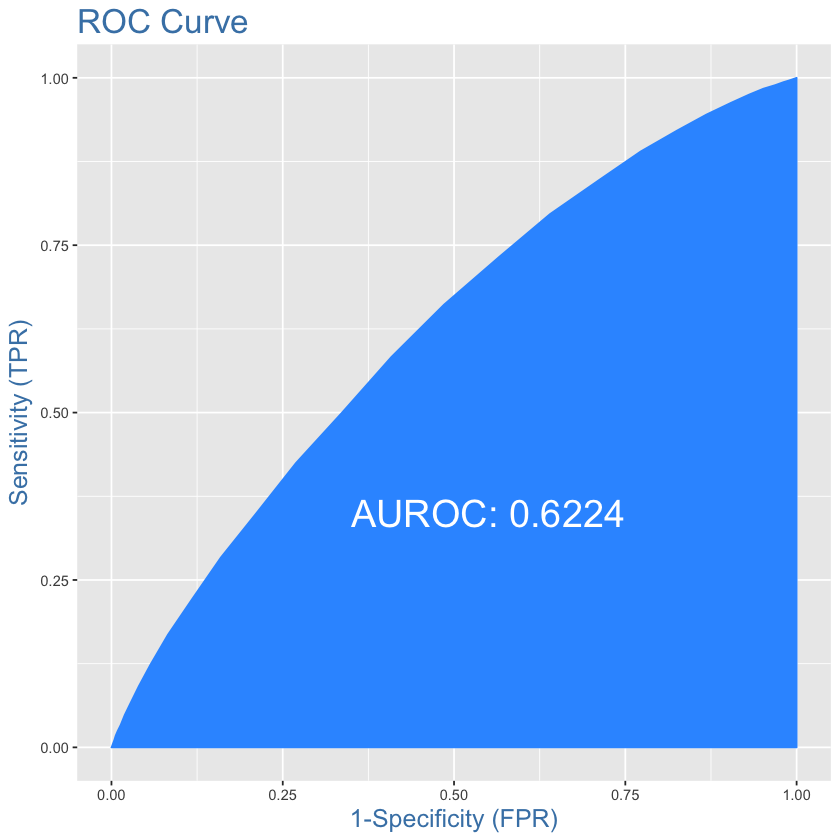

In [54]:
InformationValue::plotROC(calibration$CHURNDEP, predicted)

## Concordance

In [55]:
Concordance(calibration$CHURNDEP, predicted)

$Concordance
[1] 0.6230302

$Discordance
[1] 0.3769698

$Tied
[1] -5.551115e-17

$Pairs
[1] 400000000

## Decile analysis

In [57]:
train1<- cbind(calibration, Prob=predict(fit3, type="response")) 
train1

,REVENUE,MOU,RECCHRGE,DIRECTAS,OVERAGE,ROAM,CHANGEM,CHANGER,DROPVCE,BLCKVCE,⋯,REFER,INCMISS,INCOME,MCYCLE,CREDITAD,SETPRCM,SETPRC,RETCALL,CHURNDEP,Prob
31048,38.00,7.50,38.00,0.00,0.00,0.00,-1.50,0.00,0.00,0.00,⋯,0,0,6,0,0,1,0.00,0,0,0.6698270
31049,55.23,570.50,71.98,0.00,0.00,0.00,38.50,0.00,9.67,0.67,⋯,0,0,6,0,1,0,79.99,0,0,0.3353622
31050,38.05,682.50,52.49,0.25,0.00,0.00,147.50,-3.06,9.00,1.67,⋯,0,0,1,0,1,0,29.99,0,0,0.2726080
31051,97.34,1039.00,50.00,4.95,419.50,0.00,198.00,23.26,12.67,3.00,⋯,0,0,4,0,1,0,9.99,0,0,0.5775403
31052,35.30,24.25,34.98,0.00,0.00,0.00,19.75,-0.31,0.00,0.00,⋯,0,0,9,0,0,0,79.99,0,0,0.4573409
31053,81.00,1056.25,75.00,0.00,0.00,0.00,42.75,2.35,0.00,0.00,⋯,0,0,5,0,1,0,29.99,0,0,0.3619441
31054,63.02,440.25,59.98,0.00,5.75,1.31,-16.25,0.21,5.00,0.00,⋯,0,0,3,0,0,0,29.99,0,0,0.3411405
31055,29.99,47.00,29.99,0.00,0.00,0.00,14.00,0.00,0.33,0.00,⋯,0,0,9,0,0,0,29.99,0,0,0.3675597
31056,21.15,45.50,16.99,0.00,14.00,0.00,-15.50,-4.16,1.33,3.00,⋯,0,0,7,0,1,0,29.99,0,0,0.1944369
31057,30.00,155.75,30.00,0.00,0.00,0.00,94.25,0.00,2.00,2.00,⋯,0,0,9,0,0,0,149.99,0,0,0.4744660


In [72]:
##Creating Deciles
decLocations <- quantile(train1$Prob, probs = seq(0.1,0.9,by=0.1))
train1$decile <- findInterval(train1$Prob,c(-Inf,decLocations, Inf))



In [74]:
fit_train_DA <- train1  %>%  group_by(decile)  %>%  dplyr::summarize(Min_prob = min(Prob), Max_prob = max(Prob), Dlnq_Count = sum(CHURNDEP),
                                                      Non_Delinq_Count = (length(decile)-sum(CHURNDEP))) %>%  arrange(decile)


In [75]:
fit_train_DA <- dplyr::arrange(fit_train_DA, desc(decile))  
fit_train_DA



decile,Min_prob,Max_prob,Dlnq_Count,Non_Delinq_Count
10,0.6327145,0.9311010,2700,1300
9,0.5868984,0.6327142,2421,1579
8,0.5534180,0.5868833,2267,1733
7,0.5241201,0.5534095,2187,1813
6,0.4986427,0.5241142,2137,1863
5,0.4726285,0.4986397,1999,2001
4,0.4454844,0.4726178,1862,2138
3,0.4132792,0.4454546,1738,2262
2,0.3666019,0.4132773,1485,2515
1,0.1148548,0.3666013,1204,2796


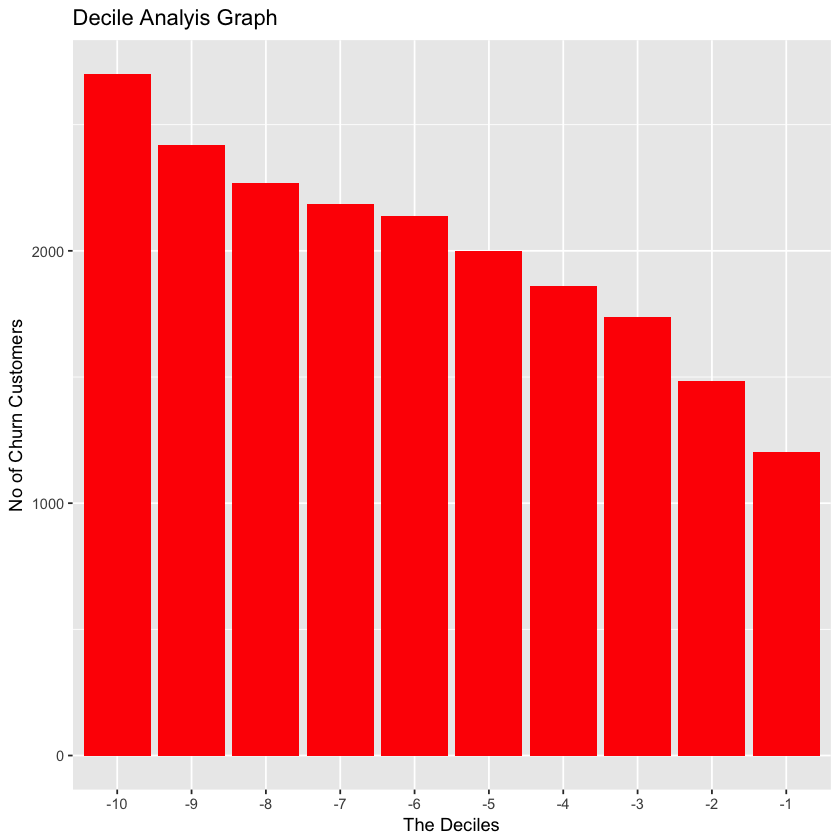

In [76]:
DecilePlot <-  ggplot2::ggplot(data = fit_train_DA,aes(x = factor(-decile), y = Dlnq_Count))

DecilePlot <- DecilePlot + geom_bar(stat = 'identity',fill = "red") 

DecilePlot <-  DecilePlot + xlab("The Deciles") + ylab("No of Churn Customers")

DecilePlot <- DecilePlot + ggtitle("Decile Analyis Graph")

DecilePlot